## Imports

In [9]:
# Standard library imports
import os
import random
import pickle

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Image processing packages
import imageio
from PIL import Image, ImageSequence

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster

In [2]:
def generate_random_spike_data(width=16, length_ms=120000, average_rate=0.5):
    """
    Generate spike times for neurons arranged in a width x width grid.
    
    Parameters:
    - width: The width of the square grid.
    - length_ms: The recording length in milliseconds.
    - average_rate: The average firing rate in Hz.
    
    Returns:
    A SpikeData object containing spike times and neuron positions.
    """
    np.random.seed(0)
    N_channels = width * width
    train = []

    # Generate spike times
    for _ in range(N_channels):
        num_spikes = np.random.poisson(average_rate * length_ms / 1000)
        spike_times = np.random.uniform(0, length_ms, num_spikes)
        train.append(spike_times)

    # Generate positions for each neuron (channel) in a width x width grid
    positions = [(x, y) for x in range(width) for y in range(width)]

    # Initialize neuron_data with positions
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}

    # Create and return SpikeData object
    spike_data = SpikeData(train, neuron_data=neuron_data)
    return spike_data

# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def plot_raster(sd, title):
    idces, times = sd.idces_times()
    # Adjust the figsize parameter to change the figure size; (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Example: 10 inches wide by 6 inches tall

    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax.set_title(title)
    plt.show()

In [19]:
# def firing_plotter(sd, global_min_rate, global_max_rate):
#     # Custom colormap from pale red/pink to dark red/black
#     colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
#     cmap_name = "custom_red_black"
#     n_bins = 100  # More bins will give us a finer gradient
#     cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

#     firing_rates = calculate_mean_firing_rates(sd)
#     neuron_x, neuron_y = [], []
#     # Extract neuron positions
#     for i, neuron in sd.neuron_data['positions'].items():
#         neuron_x.append(neuron['position'][0])
#         neuron_y.append(neuron['position'][1])
    
#     plt.figure(figsize=(8, 6))
#     # Plotting a small pale blue square at each neuron position
#     plt.scatter(neuron_x, neuron_y, s=10, c='#add8e6', marker='s', alpha=0.6)  # s is the size, c is the color
#     scatter = plt.scatter(neuron_x, neuron_y, s=firing_rates*1.5, c=firing_rates, alpha=0.6, cmap=cm, vmin=global_min_rate, vmax=75)

#     plt.title("Neuron Firing Rates")
#     plt.xlabel("X Position")
#     plt.ylabel("Y Position")
#     plt.colorbar(scatter, label='Firing Rate (Hz)')
#     plt.gca().invert_yaxis()
#     # plt.show()

def firing_plotter(sd, global_min_rate, global_max_rate):
    # Custom colormap from pale red/pink to dark red/black
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100  # More bins will give us a finer gradient
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    firing_rates = calculate_mean_firing_rates(sd)
    neuron_x, neuron_y = [], []
    # Extract neuron positions
    for i, neuron in sd.neuron_data['positions'].items():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])

    plt.figure(figsize=(8, 6))
    # Plotting a small pale blue square at each neuron position
    plt.scatter(neuron_x, neuron_y, s=10, c='#add8e6', marker='s', alpha=0.6)
    scatter = plt.scatter(neuron_x, neuron_y, s=firing_rates*1.5, c=firing_rates, alpha=0.6, cmap=cm, vmin=global_min_rate, vmax=30)

    # Creating dummy plots for the legend
    for rate in [20, 40, 60]:  # Example firing rates
        plt.scatter([], [], s=rate*1.5, c='gray', alpha=0.6, label=f'{rate} Hz')

    plt.title("Animation of Firing Rates for Random Data")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.colorbar(scatter, label='Firing Rate (Hz)')
    plt.gca().invert_yaxis()

    # Adding the legend for sizes with title
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Firing Rate', loc='upper right')

    # plt.show()

In [4]:
random_spike_data = generate_random_spike_data(width=16, length_ms=60000, average_rate=3.45)

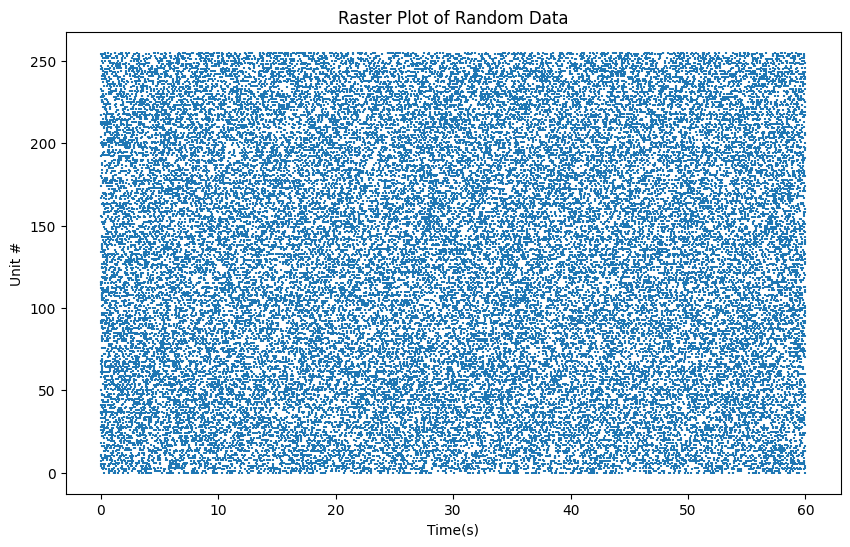

In [5]:
plot_raster(random_spike_data, "Raster Plot of Random Data")

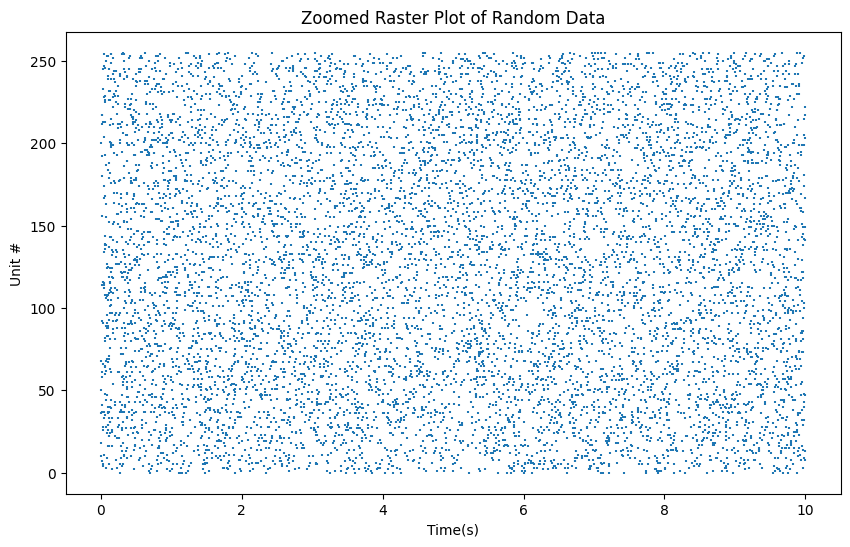

In [6]:
plot_raster(random_spike_data.subtime(0, 10000), "Zoomed Raster Plot of Random Data")

In [10]:
file_path = os.path.join('/workspaces/human_hippocampus/dev/other/thomas/thesis/pickled_datasets/', 'random_dataset.pkl')
with open(file_path, 'wb') as f:
    pickle.dump(random_spike_data, f)

/tmp/ipykernel_30601/1203322258.py:37: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for i, neuron in sd.neuron_data['positions'].items():


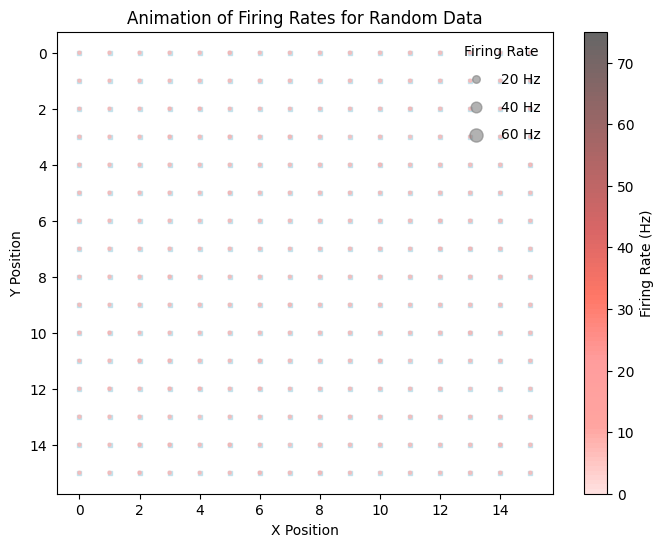

In [16]:
firing_plotter(random_spike_data, 0, 3)

In [11]:
def create_animation(sd, frames_per_second, output_dir='firing_maps_random', animation_file='firing_animation_random.gif'):
    base_path = "/workspaces/human_hippocampus/dev/other/thomas/thesis/"
    full_output_dir = os.path.join(base_path, output_dir)
    
    if not os.path.exists(full_output_dir):
        os.makedirs(full_output_dir)

    filenames = []
    
    # Adjust as necessary to capture the correct time segment
    # sd_test = sd.subtime(0, 10000)
    sd_test = sd
    total_recording_time_ms = sd_test.length  # Total recording time in milliseconds
    total_recording_time_s = total_recording_time_ms / 1000.0  # Convert ms to seconds

    # Calculate the total number of frames for the entire recording
    total_frames = int(frames_per_second * total_recording_time_s)
    
    # Calculate the global minimum and maximum firing rates for consistent coloring
    g_min_rate = np.min(calculate_mean_firing_rates(sd))
    g_max_rate = np.max(calculate_mean_firing_rates(sd))

    images = []
    for frame_number in range(total_frames):
        start_time_ms = (frame_number / frames_per_second) * 1000
        end_time_ms = ((frame_number + 1) / frames_per_second) * 1000
        sd_timestep = sd_test.subtime(start_time_ms, end_time_ms)
        
        firing_plotter(sd_timestep, global_min_rate=g_min_rate, global_max_rate=g_max_rate)
        
        filename = os.path.join(full_output_dir, f"frame_{frame_number}.png")
        plt.savefig(filename)
        plt.close()
        
        images.append(Image.open(filename))

    # Save frames to a GIF
    animation_path = os.path.join(base_path, animation_file)
    images[0].save(animation_path, save_all=True, append_images=images[1:], optimize=False, duration=int(1000 / frames_per_second), loop=0)
    
    print(f"Animation saved to {animation_path}")
    # return animation_path

In [20]:
create_animation(random_spike_data, 4)

/tmp/ipykernel_30601/681158351.py:37: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for i, neuron in sd.neuron_data['positions'].items():


Animation saved to /workspaces/human_hippocampus/dev/other/thomas/thesis/firing_animation_random.gif
